In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as torchdist
import torch.nn as nn
import pandas as pd
import numpy as np
from tqdm import tqdm

from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
pd.set_option('display.max_columns', 100)

## EDA

In [16]:
df_train = pd.read_csv('../data/real_estate/train_data.csv')
df_train.head()

,id,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,y
0,1,中古マンション等,NaN,13101,東京都,千代田区,飯田橋,飯田橋,1,２ＬＤＫ,55,NaN,NaN,NaN,昭和59年,ＳＲＣ,NaN,住宅,NaN,NaN,NaN,商業地域,80.0,600.0,2017年第４四半期,改装済,NaN,66.0
1,2,中古マンション等,NaN,13101,東京都,千代田区,飯田橋,飯田橋,5,１Ｋ,20,NaN,NaN,NaN,平成15年,ＲＣ,NaN,住宅,NaN,NaN,NaN,商業地域,80.0,500.0,2017年第４四半期,未改装,NaN,19.0
2,3,中古マンション等,NaN,13101,東京都,千代田区,飯田橋,飯田橋,3,１ＬＤＫ,45,NaN,NaN,NaN,平成24年,ＲＣ,住宅,その他,NaN,NaN,NaN,商業地域,80.0,500.0,2017年第３四半期,未改装,NaN,37.0
3,4,中古マンション等,NaN,13101,東京都,千代田区,飯田橋,飯田橋,5,１Ｒ,20,NaN,NaN,NaN,平成15年,ＲＣ,住宅,住宅,NaN,NaN,NaN,商業地域,80.0,500.0,2017年第３四半期,未改装,NaN,18.0
4,5,宅地(土地と建物),商業地,13101,東京都,千代田区,飯田橋,飯田橋,3,NaN,80,ほぼ台形,6.8,330,昭和61年,ＲＣ,住宅、事務所、店舗,事務所,南西,区道,8.0,商業地域,80.0,500.0,2017年第２四半期,NaN,NaN,240.0


種類ごとに分ける
とりあえず使える特徴量

|列名|データ型|欠損割合|検討|備考|
|:--|---|---|---|
|市区町村名          |object|0.000000|〇|
|地区名            |object|0.000690|〇|NaN->"miss_area"
|最寄り駅名：名称   |object|0.004353|〇|NaN->"miss_station"
|最寄駅：距離（分） |object|0.028425|〇|30分?60分->30, 1H?1H30->60, 1H30?2H->90, 2H?->120<br>NaNの種類：その駅の距離（時間）の中央値で置換
|間取り            |object|0.568462|X|マンション以外だと欠損<br>部屋ごとのone-hotに変えたい。
|面積（㎡）        |object|0.000000|〇|「2000㎡以上」->2000,「5000㎡以上」->5000<br>標準化するために対数とって左右対称の分布に
|土地の形状         |object|0.448446|〇|「ほぼ台形」「ほぼ長方形」など
|間口              |object|0.494132|X|'50.0m以上'->50
|延床面積（㎡）     |object|0.662845|X|「2000㎡以上」->2000,「10m^2未満」->100
|建築年            |object|0.232475|X|カテゴリのまま使用する+昭和、平成を西暦に変換<br>"宅地(土地と建物)"と"中古マンション等"以外はNaN
|建物の構造         |object|0.221216|X|「ＲＣ」「ＳＲＣ」「ＲＣ、鉄骨造」など。one-hotにしたい
|用途              |object|0.227480|X|「住宅」「住宅、事務所、店舗」など。one-hotにしたい
|今後の利用目的     |object|0.687440|〇|「住宅」「その他」「事務所」など
|前面道路：方位     |object|0.448527|〇|「南西」など
|前面道路：種類     |object|0.454536|〇|「区道」など
|前面道路：幅員（ｍ）|float64|0.457606|〇|
|都市計画           |object|0.009673|〇|「商業地域」など
|建ぺい率（％）     |float64|0.015115|X|
|容積率（％）       |float64|0.015115|X|
|取引時点           |object|0.000000|〇|
|改装               |object|0.595130|〇|「改装済」「未改装」
|取引の事情等        |object|0.921043|X|「隣地の購入」「関係者間取引」「調停・競売等」など。<br>結構情報はありそう

In [ ]:
numeric_features = ['最寄駅：距離（分）', '面積（㎡）']
categorical_features = ['市区町村名', '地区名', '最寄り駅名：名称']

欠損値

In [91]:
# df_train.isnull().mean()

データ型

In [92]:
# df_train.dtypes

### 取引金額y

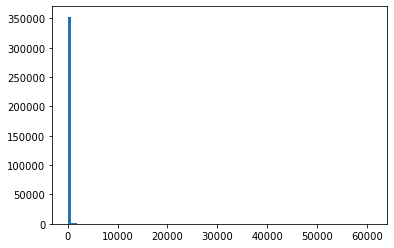

In [8]:
plt.hist(df_train['y'], bins=100);

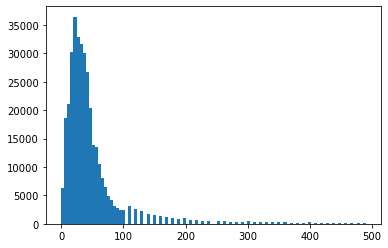

In [13]:
plt.hist(df_train.loc[df_train['y']<500, 'y'], bins=100);

偏りが大きいので対数をとる

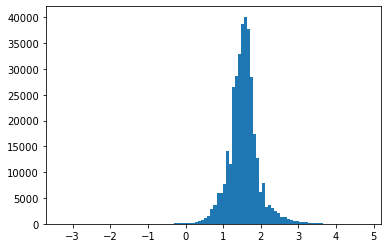

In [15]:
plt.hist(np.log10(df_train['y']), bins=100);

### 種類

不動産の種類  
（「宅地(土地/土地と建物)」「中古マンション等」「農地」「林地」など）  
「宅地（土地）」:土地のみの取引  
定義は下記の通り  
「宅地（土地と建物）」:土地と建物等を一括して取引  
「中古マンション等」:区分所有物件（戸単位）の取引

In [25]:
df_train['種類'].value_counts()

中古マンション等     158943
宅地(土地と建物)    125344
宅地(土地)        71594
林地              381
農地               82
Name: 種類, dtype: int64

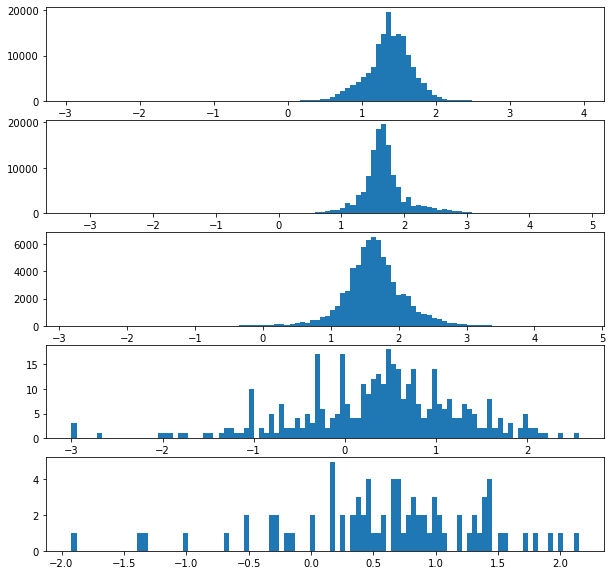

In [24]:
fig, axes = plt.subplots(5, figsize=(10, 10))
for i, estate_type in enumerate(df_train['種類'].unique()):
    is_the_type = df_train['種類'] == estate_type
    axes[i].hist(np.log10(df_train.loc[is_the_type, 'y']), bins=100)

### 市区町村名

In [26]:
df_train['市区町村名'].value_counts()

世田谷区        23288
大田区         19705
練馬区         19655
足立区         16309
杉並区         15654
板橋区         13973
八王子市        13212
江戸川区        12670
江東区         12540
新宿区         12121
品川区         11771
葛飾区         11151
港区          11001
町田市          9910
豊島区          8928
中野区          8548
文京区          8498
中央区          8421
渋谷区          8169
墨田区          7909
北区           7337
目黒区          7191
台東区          6828
府中市          5841
調布市          5359
荒川区          5356
西東京市         4570
小平市          4516
日野市          4179
立川市          4146
三鷹市          3754
千代田区         3673
青梅市          3661
東村山市         3452
国分寺市         2988
多摩市          2901
東久留米市        2681
小金井市         2681
武蔵野市         2571
昭島市          2437
あきる野市        2083
東大和市         1821
狛江市          1811
稲城市          1766
国立市          1648
武蔵村山市        1601
清瀬市          1586
羽村市          1235
福生市          1109
西多摩郡瑞穂町       796
西多摩郡日の出町      449
大島町           295
八丈町           233
西多摩郡奥多摩町      141
三宅村            72
小笠原村      

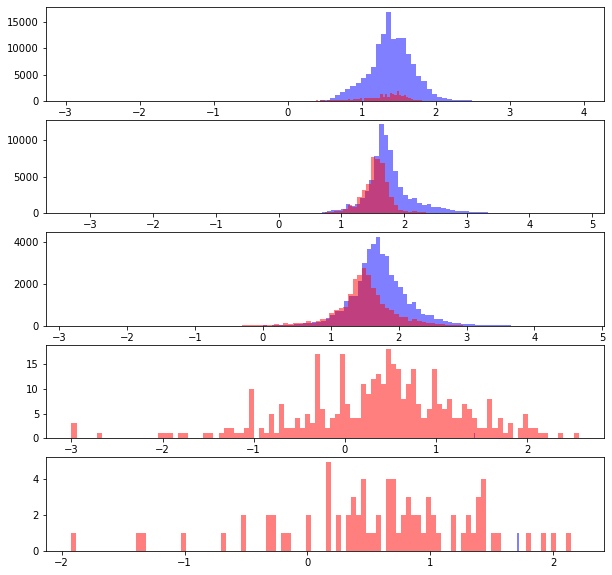

In [83]:
fig, axes = plt.subplots(5, figsize=(10, 10))
for i, estate_type in enumerate(df_train['種類'].unique()):
    is_the_type = df_train['種類'] == estate_type
    axes[i].hist(np.log10(df_train.loc[is_the_type & is_ku, 'y']), bins=100, color='blue', alpha=0.5)
    axes[i].hist(np.log10(df_train.loc[is_the_type & ~is_ku, 'y']), bins=100, color='red', alpha=0.5)

### 地区名

In [158]:
df_train[df_train['地区名'].isnull()].head()

,id,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,y
39020,39021,宅地(土地),商業地,13101,東京都,千代田区,NaN,神保町,6,NaN,95,長方形,7.0,NaN,NaN,NaN,NaN,NaN,南東,区道,11.0,商業地域,80.0,500.0,2010年第４四半期,NaN,NaN,120.0
39021,39022,中古マンション等,NaN,13101,東京都,千代田区,NaN,神保町,7,１Ｒ,25,NaN,NaN,NaN,平成21年,ＲＣ,住宅,NaN,NaN,NaN,NaN,商業地域,80.0,600.0,2010年第２四半期,未改装,NaN,27.0
39546,39547,宅地(土地と建物),商業地,13101,東京都,千代田区,NaN,水道橋,4,NaN,165,ほぼ長方形,15.5,370,昭和47年,ＲＣ,共同住宅、事務所、店舗,NaN,南東,私道,2.7,商業地域,80.0,700.0,2010年第４四半期,NaN,NaN,500.0
39547,39548,宅地(土地と建物),商業地,13101,東京都,千代田区,NaN,水道橋,4,NaN,600,不整形,11.0,2000㎡以上,昭和62年,ＳＲＣ,事務所,NaN,北東,区道,22.0,商業地域,80.0,600.0,2010年第４四半期,NaN,NaN,2700.0
39548,39549,宅地(土地と建物),商業地,13101,東京都,千代田区,NaN,水道橋,4,NaN,115,長方形,8.0,370,昭和43年,ＲＣ,住宅、事務所、作業場,NaN,南東,区道,5.5,商業地域,80.0,500.0,2010年第４四半期,NaN,NaN,150.0


In [138]:
df_train[df_train['最寄駅：名称'] == '水道橋'].head()

,id,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,y
61,62,宅地(土地と建物),商業地,13101,東京都,千代田区,飯田橋,水道橋,2,NaN,80,ほぼ台形,6.7,55,平成5年,鉄骨造,駐車場,その他,東,区道,11.7,商業地域,80.0,500.0,2016年第４四半期,NaN,NaN,250.0
462,463,中古マンション等,NaN,13101,東京都,千代田区,神田猿楽町,水道橋,4,１ＬＤＫ,40,NaN,NaN,NaN,平成25年,ＲＣ,NaN,その他,NaN,NaN,NaN,商業地域,80.0,500.0,2017年第４四半期,NaN,NaN,39.0
463,464,中古マンション等,NaN,13101,東京都,千代田区,神田猿楽町,水道橋,4,１Ｋ,20,NaN,NaN,NaN,平成14年,ＳＲＣ,NaN,住宅,NaN,NaN,NaN,商業地域,80.0,500.0,2017年第４四半期,未改装,NaN,25.0
464,465,中古マンション等,NaN,13101,東京都,千代田区,神田猿楽町,水道橋,4,１Ｋ,20,NaN,NaN,NaN,平成14年,ＳＲＣ,住宅,その他,NaN,NaN,NaN,商業地域,80.0,500.0,2017年第３四半期,NaN,NaN,24.0
465,466,中古マンション等,NaN,13101,東京都,千代田区,神田猿楽町,水道橋,4,１ＬＤＫ,40,NaN,NaN,NaN,平成25年,ＲＣ,住宅,住宅,NaN,NaN,NaN,商業地域,80.0,500.0,2017年第１四半期,未改装,NaN,37.0


### 最寄駅：距離（分）

「30分?60分」というデータがあるのでどうにか対処する

In [104]:
(df_train['最寄駅：距離（分）'] == '30分?60分').sum()

10007

In [185]:
def feat_moyori(df):
    tmp = df['最寄駅：距離（分）']
    tmp[tmp == '30分?60分'] = '30'
    tmp[tmp == '1H?1H30'] = '60'
    tmp[tmp == '1H30?2H'] = '90'
    tmp[tmp == '2H?'] = '120'
    tmp = tmp.astype(np.float64)
    df['最寄駅：距離（分）'] = tmp
    return df
# plt.hist(df_train.loc[df_train['最寄駅：距離（分）'].notnull(), '最寄駅：距離（分）'])
df_train = feat_moyori(df_train)

C:\Users\galois\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\galois\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\galois\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

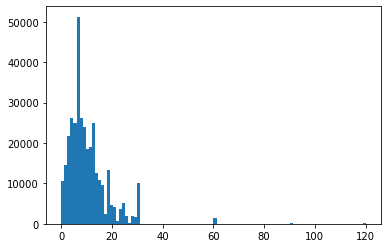

In [154]:
plt.hist(tmp[tmp.notnull()], bins=100);

In [171]:
print(tmp.isnull().sum())
df_train[tmp.isnull()][5000:5020]

10129


,id,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,y
190057,190058,中古マンション等,NaN,13111,東京都,大田区,多摩川,矢口渡,NaN,１Ｋ,20,NaN,NaN,NaN,平成18年,ＲＣ,住宅,NaN,NaN,NaN,NaN,第１種住居地域,60.0,200.0,2006年第３四半期,未改装,NaN,21.0
190059,190060,中古マンション等,NaN,13111,東京都,大田区,多摩川,矢口渡,NaN,１Ｋ,20,NaN,NaN,NaN,平成18年,ＲＣ,住宅,NaN,NaN,NaN,NaN,近隣商業地域,80.0,300.0,2006年第３四半期,未改装,NaN,22.0
190061,190062,中古マンション等,NaN,13111,東京都,大田区,多摩川,矢口渡,NaN,１Ｋ,20,NaN,NaN,NaN,平成18年,ＲＣ,住宅,NaN,NaN,NaN,NaN,近隣商業地域,80.0,300.0,2006年第３四半期,未改装,NaN,23.0
190063,190064,中古マンション等,NaN,13111,東京都,大田区,多摩川,矢口渡,NaN,１Ｋ,20,NaN,NaN,NaN,平成18年,ＲＣ,住宅,NaN,NaN,NaN,NaN,近隣商業地域,80.0,300.0,2006年第３四半期,未改装,NaN,23.0
190065,190066,中古マンション等,NaN,13111,東京都,大田区,多摩川,矢口渡,NaN,１Ｋ,20,NaN,NaN,NaN,平成18年,ＲＣ,住宅,NaN,NaN,NaN,NaN,準工業地域,60.0,200.0,2006年第３四半期,未改装,NaN,24.0
190067,190068,中古マンション等,NaN,13111,東京都,大田区,多摩川,矢口渡,NaN,１Ｋ,20,NaN,NaN,NaN,平成18年,ＲＣ,住宅,NaN,NaN,NaN,NaN,準工業地域,60.0,200.0,2006年第３四半期,未改装,NaN,16.0
190071,190072,中古マンション等,NaN,13111,東京都,大田区,多摩川,矢口渡,NaN,２ＬＤＫ,40,NaN,NaN,NaN,平成18年,ＲＣ,住宅,NaN,NaN,NaN,NaN,準工業地域,60.0,300.0,2006年第２四半期,NaN,NaN,34.0
190077,190078,中古マンション等,NaN,13111,東京都,大田区,多摩川,矢口渡,NaN,１Ｋ,25,NaN,NaN,NaN,平成18年,ＲＣ,住宅,NaN,NaN,NaN,NaN,準工業地域,60.0,200.0,2006年第２四半期,未改装,NaN,22.0
190079,190080,中古マンション等,NaN,13111,東京都,大田区,多摩川,矢口渡,NaN,１Ｋ,20,NaN,NaN,NaN,平成18年,ＲＣ,住宅,NaN,NaN,NaN,NaN,準工業地域,60.0,200.0,2006年第２四半期,未改装,NaN,21.0
190083,190084,中古マンション等,NaN,13111,東京都,大田区,多摩川,矢口渡,NaN,１Ｋ,20,NaN,NaN,NaN,平成18年,ＲＣ,住宅,NaN,NaN,NaN,NaN,準工業地域,60.0,200.0,2006年第２四半期,未改装,NaN,23.0


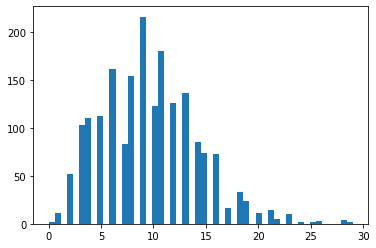

In [178]:
is_omori = df_train['最寄駅：名称'] == '大森(東京)'
is_null = df_train['最寄駅：距離（分）'].isnull()

plt.hist(df_train.loc[is_omori & ~is_null, '最寄駅：距離（分）'].astype(np.float64), bins=50);

### 間取り

In [38]:
df_train.loc[df_train['種類'] == '宅地(土地)', '間取り'].unique()

array([nan], dtype=object)

In [39]:
df_train.loc[df_train['種類'] == '宅地(土地と建物)', '間取り'].unique()

array([nan], dtype=object)

In [40]:
df_train.loc[df_train['種類'] == '中古マンション等', '間取り'].unique()

array(['２ＬＤＫ', '１Ｋ', '１ＬＤＫ', '１Ｒ', nan, '３ＬＤＫ', '１ＤＫ＋Ｓ', '３ＤＫ', '１ＤＫ',
       '２ＤＫ', 'オープンフロア', '４ＬＤＫ', '１Ｋ＋Ｓ', '１ＬＤＫ＋Ｓ', '２ＬＤＫ＋Ｓ', 'スタジオ', '２Ｋ',
       '２ＤＫ＋Ｓ', '３ＬＤＫ＋Ｓ', '３Ｋ', '４ＤＫ', '５ＬＤＫ＋Ｓ', '７ＬＤＫ', '２Ｋ＋Ｓ', 'メゾネット',
       '５ＬＤＫ', '３ＤＫ＋Ｓ', '４Ｋ', '４ＬＤＫ＋Ｓ', '２ＬＤ', '３ＬＫ', '１Ｒ＋Ｓ', '１ＬＫ',
       '２ＬＤ＋Ｓ', '５ＤＫ', '１Ｌ', '２ＬＫ＋Ｓ', '６ＬＤＫ', '２ＬＫ', '１Ｌ＋Ｓ', '６ＬＤＫ＋Ｓ',
       '６ＤＫ', '４ＤＫ＋Ｓ', '３Ｋ＋Ｓ', '３ＬＤ＋Ｓ', '１ＬＤ＋Ｓ', '３ＬＤ', '２Ｄ', '３ＬＤＫ＋Ｋ'],
      dtype=object)

In [41]:
df_train.loc[df_train['種類'] == '林地', '間取り'].unique()

array([nan], dtype=object)

In [42]:
df_train.loc[df_train['種類'] == '農地', '間取り'].unique()             

array([nan], dtype=object)

### 面積

In [49]:
df_train['面積（㎡）'].head()

0    55
1    20
2    45
3    20
4    80
Name: 面積（㎡）, dtype: object

In [50]:
s = pd.to_numeric(df_train['面積（㎡）'], errors='coerce')

全体の0.366%は、面積が数値でない

In [51]:
print('%d(%f)' % (s.isnull().sum(), s.isnull().mean()))

0(0.000000)


面積が文字列となっているレコードは、2000㎡以上か5000㎡以上の値になっている

In [52]:
df_train.loc[s.isnull(), '面積（㎡）'].value_counts()

Series([], Name: 面積（㎡）, dtype: int64)

In [53]:
df_train.loc[s.isnull(), '種類'].value_counts()

Series([], Name: 種類, dtype: int64)

In [54]:
df_train[(df_train['種類']=='中古マンション等') & s.isnull()]

,id,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,y,面積


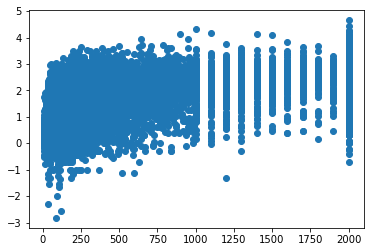

In [55]:
is_the = (df_train['種類']=='宅地(土地)') & s.notnull()
s[is_the].head()

# tmp = df_train[(df_train['種類']=='宅地(土地)') & s.notnull()]
plt.plot(s[is_the], np.log10(df_train.loc[is_the, 'y']), 'o');

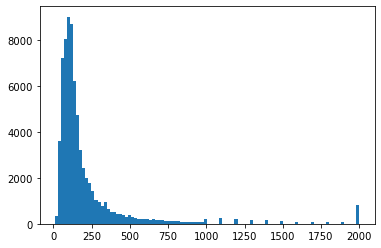

In [59]:
plt.hist(s[is_the], bins=100);

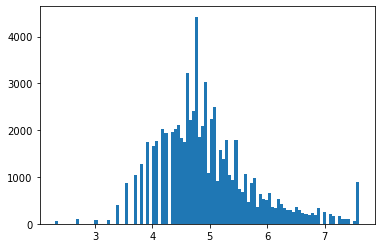

In [60]:
plt.hist(np.log10(s[is_the]), bins=100);

### 間口, 延床面積（㎡）

In [120]:
df_train['間口'].astype(np.float64)

ValueError: could not convert string to float: '50.0m以上'

In [118]:
# 
s = pd.to_numeric(df_train['延床面積（㎡）'], errors='coerce')

In [119]:
df_train.loc[s.isnull(), '延床面積（㎡）'].unique()

array([nan, '2000㎡以上', '10m^2未満'], dtype=object)

### 建築年

In [121]:
df_train['建築年'].unique()

array(['昭和59年', '平成15年', '平成24年', '昭和61年', '平成11年', '昭和60年', '平成19年',
       '平成10年', nan, '昭和57年', '昭和45年', '昭和47年', '昭和43年', '昭和64年', '平成25年',
       '平成16年', '平成9年', '平成5年', '昭和51年', '平成13年', '昭和52年', '昭和55年',
       '昭和54年', '平成2年', '平成21年', '平成22年', '平成18年', '平成14年', '平成6年',
       '平成17年', '昭和62年', '平成12年', '昭和38年', '昭和41年', '昭和48年', '平成20年',
       '昭和53年', '昭和49年', '平成26年', '昭和58年', '昭和56年', '昭和35年', '昭和50年',
       '昭和37年', '平成23年', '平成7年', '平成3年', '昭和63年', '戦前', '平成29年', '昭和36年',
       '平成28年', '昭和39年', '平成4年', '平成27年', '昭和42年', '昭和31年', '平成30年',
       '昭和44年', '昭和29年', '平成8年', '昭和27年', '昭和46年', '昭和30年', '昭和33年',
       '昭和32年', '昭和40年', '昭和26年', '昭和34年', '昭和25年', '昭和28年', '昭和22年',
       '昭和24年', '昭和23年', '昭和21年', '平成31年'], dtype=object)

In [43]:
df_train.loc[df_train['種類'] == '宅地(土地)', '建築年'].unique()

array([nan], dtype=object)

In [44]:
df_train.loc[df_train['種類'] == '中古マンション等', '建築年'].unique()

array(['昭和59年', '平成15年', '平成24年', '平成11年', '昭和60年', '平成19年', '平成10年', nan,
       '昭和57年', '平成25年', '平成16年', '平成9年', '昭和51年', '昭和47年', '平成13年',
       '昭和52年', '昭和45年', '昭和54年', '平成21年', '平成18年', '平成14年', '平成17年',
       '平成12年', '平成20年', '平成26年', '昭和56年', '平成23年', '平成22年', '昭和55年',
       '平成27年', '平成28年', '昭和53年', '昭和63年', '昭和50年', '昭和61年', '平成3年',
       '昭和58年', '平成4年', '昭和46年', '昭和44年', '平成8年', '昭和48年', '昭和49年',
       '平成5年', '平成6年', '平成29年', '平成7年', '平成2年', '昭和64年', '昭和62年', '昭和39年',
       '昭和35年', '昭和34年', '昭和41年', '戦前', '昭和43年', '昭和40年', '昭和42年',
       '昭和25年', '昭和38年', '平成30年', '昭和37年', '昭和36年', '昭和24年', '昭和31年',
       '昭和33年', '昭和22年', '昭和21年', '昭和28年'], dtype=object)

In [45]:
df_train.loc[df_train['種類'] == '宅地(土地と建物)', '建築年'].unique()

array(['昭和61年', '昭和57年', '昭和45年', '昭和47年', '昭和43年', '昭和64年', '平成5年',
       '昭和55年', nan, '平成11年', '平成2年', '平成22年', '平成6年', '昭和62年', '昭和38年',
       '昭和60年', '昭和41年', '昭和48年', '昭和53年', '昭和49年', '昭和58年', '昭和59年',
       '昭和35年', '平成12年', '昭和50年', '昭和37年', '平成15年', '平成7年', '平成3年',
       '昭和63年', '昭和56年', '平成26年', '戦前', '平成29年', '昭和36年', '平成28年', '平成9年',
       '昭和39年', '平成4年', '昭和51年', '昭和42年', '昭和31年', '平成30年', '平成16年',
       '昭和44年', '平成18年', '平成25年', '昭和29年', '昭和54年', '平成8年', '昭和27年',
       '平成20年', '昭和52年', '平成10年', '平成17年', '平成19年', '平成21年', '昭和30年',
       '昭和33年', '昭和32年', '昭和46年', '平成27年', '昭和40年', '昭和26年', '平成23年',
       '昭和34年', '昭和25年', '平成13年', '平成14年', '昭和28年', '昭和22年', '平成24年',
       '昭和24年', '昭和23年', '昭和21年', '平成31年'], dtype=object)

In [46]:
df_train.loc[df_train['種類'] == '林地', '建築年'].unique()

array([nan], dtype=object)

In [47]:
df_train.loc[df_train['種類'] == '農地', '建築年'].unique()

array([nan], dtype=object)

### 建物の構造, 用途, 今後の利用目的, 都市計画, 取引時点, 改装

In [105]:
df_train['建物の構造'].unique()

array(['ＳＲＣ', 'ＲＣ', nan, '鉄骨造', '木造', '鉄骨造、軽量鉄骨造', 'ＳＲＣ、ＲＣ', '軽量鉄骨造',
       '鉄骨造、木造', 'ＲＣ、鉄骨造', 'ＲＣ、木造', '木造、ブロック造', 'ＳＲＣ、鉄骨造', '木造、軽量鉄骨造',
       'ブロック造', 'ＲＣ、木造、ブロック造', '鉄骨造、ブロック造', 'ＲＣ、鉄骨造、木造', 'ＳＲＣ、木造',
       'ＲＣ、ブロック造', 'ＲＣ、軽量鉄骨造', 'ブロック造、軽量鉄骨造', '鉄骨造、木造、軽量鉄骨造',
       'ＲＣ、鉄骨造、ブロック造', 'ＲＣ、鉄骨造、木造、ブロック造'], dtype=object)

In [106]:
df_train['用途'].unique()

array([nan, '住宅', '住宅、事務所、店舗', 'その他', '事務所、倉庫', '事務所', '事務所、倉庫、駐車場、その他',
       '駐車場', '共同住宅', '共同住宅、店舗', '事務所、店舗', '住宅、店舗', '共同住宅、事務所、倉庫、店舗',
       '住宅、作業場、店舗', '共同住宅、事務所、店舗', '住宅、事務所', '事務所、倉庫、駐車場', '住宅、事務所、その他',
       '店舗', '事務所、その他', '事務所、倉庫、店舗', '住宅、倉庫、店舗、その他', '住宅、事務所、倉庫、店舗',
       '事務所、作業場、倉庫', '事務所、駐車場', '工場', '住宅、倉庫', '住宅、共同住宅、工場、倉庫', '倉庫',
       '事務所、駐車場、店舗', '住宅、工場、事務所', '共同住宅、事務所、倉庫、駐車場', '住宅、事務所、倉庫',
       '住宅、作業場', '共同住宅、事務所', '住宅、事務所、店舗、その他', '住宅、駐車場、店舗', '住宅、工場',
       '住宅、事務所、駐車場', '事務所、倉庫、その他', '住宅、その他', '住宅、作業場、倉庫、店舗',
       '住宅、共同住宅、事務所、店舗', '共同住宅、事務所、倉庫', '事務所、店舗、その他', '店舗、その他',
       '住宅、事務所、倉庫、駐車場', '共同住宅、その他', '住宅、事務所、作業場', '作業場、倉庫、駐車場', '工場、事務所',
       '住宅、共同住宅、工場、事務所', '住宅、作業場、倉庫', '倉庫、店舗', '事務所、作業場、店舗',
       '住宅、事務所、駐車場、店舗', '共同住宅、駐車場', '共同住宅、作業場', '住宅、店舗、その他', '住宅、倉庫、店舗',
       '住宅、事務所、作業場、店舗', '住宅、共同住宅、事務所、倉庫', '共同住宅、事務所、作業場', '住宅、駐車場',
       '住宅、倉庫、その他', '住宅、共同住宅、店舗', '事務所、駐車場、その他', '住宅、共同住宅、作業場',
       '住宅、共同住宅、工場、事務所、作業場、倉庫', '共同住宅、工場、事務所、駐

In [108]:
df_train['今後の利用目的'].unique()

array(['住宅', 'その他', '事務所', nan, '店舗', '倉庫', '工場'], dtype=object)

In [109]:
df_train['都市計画'].unique()

array(['商業地域', nan, '第１種住居地域', '第２種住居地域', '準工業地域', '準住居地域',
       '第１種中高層住居専用地域', '第２種中高層住居専用地域', '近隣商業地域', '第１種低層住居専用地域',
       '第２種低層住居専用地域', '工業地域', '工業専用地域', '市街化調整区域', '準都市計画区域', '都市計画区域外',
       '市街化区域及び市街化調整区域外の都市計画区域'], dtype=object)

In [110]:
df_train['取引時点'].unique()

array(['2017年第４四半期', '2017年第３四半期', '2017年第２四半期', '2017年第１四半期',
       '2016年第４四半期', '2016年第３四半期', '2016年第２四半期', '2016年第１四半期',
       '2015年第４四半期', '2015年第３四半期', '2015年第２四半期', '2015年第１四半期',
       '2014年第４四半期', '2014年第３四半期', '2014年第２四半期', '2014年第１四半期',
       '2010年第４四半期', '2010年第３四半期', '2010年第２四半期', '2010年第１四半期',
       '2011年第４四半期', '2011年第３四半期', '2011年第２四半期', '2011年第１四半期',
       '2012年第４四半期', '2012年第３四半期', '2012年第１四半期', '2012年第２四半期',
       '2013年第４四半期', '2013年第３四半期', '2013年第２四半期', '2013年第１四半期',
       '2009年第４四半期', '2009年第３四半期', '2009年第２四半期', '2009年第１四半期',
       '2008年第４四半期', '2008年第３四半期', '2008年第２四半期', '2007年第４四半期',
       '2007年第３四半期', '2007年第１四半期', '2006年第４四半期', '2006年第３四半期',
       '2006年第２四半期', '2006年第１四半期', '2005年第４四半期', '2005年第３四半期',
       '2008年第１四半期', '2007年第２四半期'], dtype=object)

In [111]:
df_train['改装'].unique()

array(['改装済', '未改装', nan], dtype=object)

In [113]:
df_train['取引の事情等'].unique()

array([nan, '私道を含む取引', '隣地の購入', '関係者間取引', '調停・競売等', '隣地の購入、私道を含む取引',
       '隣地の購入、関係者間取引、私道を含む取引', '関係者間取引、私道を含む取引', 'その他事情有り',
       '調停・競売等、私道を含む取引', '瑕疵有りの可能性', '古屋付き・取壊し前提', '隣地の購入、関係者間取引',
       '私道を含む取引、その他事情有り', '他の権利・負担付き', '隣地の購入、その他事情有り',
       '瑕疵有りの可能性、私道を含む取引', '隣地の購入、調停・競売等、私道を含む取引', '古屋付き・取壊し前提、私道を含む取引',
       '他の権利・負担付き、私道を含む取引', '関係者間取引、調停・競売等、私道を含む取引', '他の権利・負担付き、調停・競売等',
       '調停・競売等、その他事情有り', '古屋付き・取壊し前提、瑕疵有りの可能性', '隣地の購入、瑕疵有りの可能性',
       '隣地の購入、調停・競売等'], dtype=object)

## publish price

In [163]:
df_pub = pd.read_csv('../data/real_estate/published_land_price.csv')

In [ ]:
# df_pub.iloc[:5, :50]

## Train

### common

In [3]:
import logging
import logging.handlers


def create_logger(log_file_name):
    logger_ = logging.getLogger('main')
    logger_.setLevel(logging.DEBUG)
    fh = logging.handlers.RotatingFileHandler(
        log_file_name, maxBytes=100000, backupCount=8)
    fh.setLevel(logging.DEBUG)
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    formatter = logging.Formatter(
        '[%(levelname)s]%(asctime)s:%(name)s:%(message)s')
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)
    # add the handlers to the logger
    logger_.addHandler(fh)
    logger_.addHandler(ch)


def get_logger():
    return logging.getLogger('main')

### process

In [4]:
# 整形

def transform_y(df):
    df['y'] = np.log10(df['y'])

def feat_district_nan(df):
    df['地区名'].fillna('miss_area', inplace=True)

def feat_area_transform(df):
    df.loc[df['面積（㎡）'] == '2000㎡以上', '面積（㎡）'] = 2000
    df.loc[df['面積（㎡）'] == '5000㎡以上', '面積（㎡）'] = 5000    

    df['面積（㎡）'] = np.log10(df['面積（㎡）'].astype(np.float32))
    
def feat_station_nan(df):    
    df['最寄駅：名称'].fillna('miss_station', inplace=True)

def feat_moyori_transform(df):
    tmp = df['最寄駅：距離（分）']
    tmp[tmp == '30分?60分'] = '30'
    tmp[tmp == '1H?1H30'] = '60'
    tmp[tmp == '1H30?2H'] = '90'
    tmp[tmp == '2H?'] = '120'
    tmp = tmp.astype(np.float64)
    df['最寄駅：距離（分）'] = tmp    

def feat_moyori_nan(df):
    tostation_dict = {}
    
    is_null = df['最寄駅：距離（分）'].isnull()
    stations = df.loc[is_null, '最寄駅：名称'].unique()
    for st in tqdm(stations):
        is_station = df['最寄駅：名称'] == st
        is_notnull_station = is_station & ~is_null
        
        n_notnull = is_notnull_station.sum()
        if n_notnull == 0:
            # 最寄り駅までの時間の全体の中央値
            moyori_minute = 8.0
        else:
            moyori_minute = df.loc[is_notnull_station, '最寄駅：距離（分）'].median()
            
        df.loc[is_station & is_null, '最寄駅：距離（分）'] = moyori_minute
        tostation_dict[st] = moyori_minute
        
        return tostation_dict

def feat_maguchi_transform(df):
    df.loc[df['間口'] == '50.0m以上', '間口'] = 50

def feat_nobeyuka_transform(df):
    df.loc[df['延床面積（㎡）'] == '2000㎡以上', '延床面積（㎡）'] = 2000
    df.loc[df['延床面積（㎡）'] == '10m^2未満', '延床面積（㎡）'] = 10
    
def preprocess(df, mode):
    if mode == 'train':
        transform_y(df)
        
    # 地区名
    feat_district_nan(df)
    
    # 面積（㎡）
    feat_area_transform(df)
    
    # 最寄駅：距離（分）
    feat_moyori_transform(df)
    feat_moyori_nan(df)
    
    return df

def std_scale(df, num_feat):
    num_x = df[num_feat]
    scaler = StandardScaler()
    df[num_feat] = scaler.fit_transform(num_x)
    
    return scaler

In [5]:
def label_encode(df, categorical_features):
    label_encoders = {}
    for cat_col in categorical_features:
        label_encoders[cat_col] = LabelEncoder()
        # fill missing values with <Miising> tokens
        # train[cat_col] = train[cat_col].fillna('<Missing>')
        df[cat_col] = label_encoders[cat_col].fit_transform(df[cat_col])
    
    return label_encoders

def get_emb_dims(df, categorical_features):
    cat_dims = [int(df[col].nunique()) for col in categorical_features]
    emb_dims = [(x, min(50, (x + 1) // 2)) for x in cat_dims]
    return emb_dims

In [6]:
class RealEstateDataset(Dataset):

    def __init__(self, df, mode, num_feat, cat_feat):
        # self.data_size = data_size
        self.mode = mode
        self.num_feat = num_feat
        self.cat_feat = cat_feat
        
        # preprocess
        df = preprocess(df, mode)
        
        self.std_scaler = std_scale(df, num_feat)
        
        self.encoders = label_encode(df, cat_feat)
        self.emb_dims = get_emb_dims(df, cat_feat)
        
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if self.mode in ['train', 'valid']:
            num_x = self.df[self.num_feat]
            cat_x = self.df[self.cat_feat]
            y = self.df['y']
            
        elif self.mode in ['predict']:
            num_x = self.df[self.num_feat]
            cat_x = self.df[self.cat_feat]
            y = None
            
        else:
            raise ValueError('unkown mode')
            
        return num_x, cat_x, y
        

In [7]:
class NNModel(torch.nn.Module):
    def __init__(self, emb_dims, n_num_x):
        super(NNModel, self).__init__()
        
        self.emb_layers = torch.nn.ModuleList([torch.nn.Embedding(x, y) for x, y in emb_dims])
        n_cat_x = sum([y for _, y in emb_dims])
        self.layer1 = torch.nn.Sequence(
            torch.nn.Linear(n_cat_x + n_num_x, 16),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(16)
        )
        self.out_layer = torch.nn.Linear(16, 1)
        
    def forward(self, num_x, cat_x):
        cat_x = [emb_layer(cat_x[:, i]) for i, emb_layer in enumerate(self.emb_layers)]
        cat_x = torch.cat(cat_x, 1)
        
        x = torch.cat([num_x, cat_x], 1)
        x = self.layer1(x)
        x = self.out_layer(x)
        return x

In [8]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [14]:
class config:
    TRAIN_PATH = '../data/real_estate/train_data.csv'
    OUTDIR_PATH = '../model/best_model.pth'
    
    EPOCHS = 20
    
    NUM_WORKERS = 1
    BATCH_SIZE_TRAIN = 32
    BATCH_SIZE_TEST = BATCH_SIZE_TRAIN
    
    ADAM_LR = 1e-4

def train():
    # Load csv
    df_all = pd.read_csv(config.TRAIN_PATH)
    # TODO: 
    df_trn, df_val = train_test_split(df_all, train_size=0.8, random_state=2020)
    print('train data')
    print(df_trn.head(2))
    print('validate data')
    print(df_val.head(2))
    
    numeric_features = ['最寄駅：距離（分）', '面積（㎡）']
    categorical_features = ['市区町村名', '地区名', '最寄り駅名：名称']

    train_dataset = RealEstateDataset(
        df_trn, 'train', numeric_features, categorical_features)
    train_loader = DataLoader(train_dataset,
                              batch_size=config.BATCH_SIZE_TRAIN,
                              num_workers=config.NUM_WORKERS,
                              pin_memory=True,
                              drop_last=True,
                              shuffle=True
                              )    
    valid_dataset = RealEstateDataset(
        df_val, 'valid', numeric_features, categorical_features)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=config.BATCH_SIZE_TEST,
                              num_workers=config.NUM_WORKERS,
                              pin_memory=True,
                              drop_last=False,
                              shuffle=False
                              )

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model, criterion, optimizer, scheduler = init_model()
    start_epoch = 0

    get_logger().info('[Start] Training')
    best_score = 1e+8
    train_history = {'loss': []}
    valid_history = {'loss': []}
    for epoch in range(start_epoch + 1, config.EPOCHS + 1):

        train_loss = train_one_epoch(
            epoch, model, train_loader, criterion, optimizer, device)
        train_history['loss'].append(train_loss)

        valid_loss = validate_one_epoch(epoch, model, valid_loader, criterion, device)
        valid_history['loss'].append(valid_loss)

        is_best = valid_loss < best_score
        if is_best:
            best_score = valid_loss
        get_logger().info('best score (%f) at epoch (%d)' % (best_score, epoch))
        '''
        save_checkpoint({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
        }, is_best, config.OUTDIR_PATH)
        '''
        scheduler.step()

    return train_history, valid_history

In [10]:
def init_model(capsule):
    torch.backends.cudnn.benchmark = True
    get_logger().info('Initializing model...')
    
    model = NNModel(capsule['emb_dims'], n_num_x)

    
    # criterion = SmoothL1Loss()
    criterion = MSELoss()

    '''
    optimizer = torch.optim.SGD([{'params': model.parameters()}],
                                lr=config.SGD_LR,
                                momentum=config.MOMENTUM,
                                weight_decay=config.WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, config.ITER_PER_CYCLE, config.MIN_LR)
    '''
    optimizer = optim.Adam([{'params': model.parameters()}], lr=config.ADAM_LR)
    mile_stones = [5, 10]
    scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer, mile_stones, gamma=0.5, last_epoch=-1)

    return model, criterion, optimizer, scheduler

In [11]:
def train_one_epoch(epoch,
                    model,
                    loader,
                    criterion,
                    optimizer,
                    device):
    loss_meter = AverageMeter()
    lr = optimizer.state_dict()['param_groups'][0]['lr']

    get_logger().info('[Start] epoch: %d' % epoch)
    get_logger().info('lr: %f' % lr)

    # train phase
    model.train()
    for i, (num_x, cat_x, y_true) in enumerate(tqdm(loader)):
        num_x, cat_x, y_true = num_x.to(device), cat_x.to(device), y_true.to(device)

        with torch.set_grad_enabled(True):
            
            logit = model(num_x, cat_x)
            # print(logit.size())
            loss = criterion(logit, y_true)
            # loss = mixup_criterion(criterion, logit, label_a, label_b, lam)

            # backward
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

        loss_meter.update(loss.item(), img.size(0))

        # print
        if i % config.PRINT_FREQ == 0:
            logit_cpu = logit.detach().cpu()
            get_logger().info('\n' + str_stats(logit_cpu.numpy()))            
            get_logger().info('train: %d loss: %f (just now)' % (i, loss_meter.val))
            get_logger().info('train: %d loss: %f' % (i, loss_meter.avg))

    get_logger().info("Epoch %d/%d train loss %f" %
                      (epoch, config.EPOCHS, loss_meter.avg))

    return loss_meter.avg

In [13]:
create_logger('../log/real_estate.log')

train()

C:\Users\galois\Anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\galois\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\galois\Anaconda3\envs\py36\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\galois\Anaconda3\envs\py36\lib\site-packages\pandas\cor

AttributeError: 'str' object has no attribute 'log10'

In [15]:
np

<module 'numpy' from 'C:\\Users\\galois\\Anaconda3\\envs\\py36\\lib\\site-packages\\numpy\\__init__.py'>